In [1]:
!pip install shap

You should consider upgrading via the 'c:\users\victor\anaconda3\python.exe -m pip install --upgrade pip' command.


In [2]:
import pickle
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, recall_score, precision_score, f1_score, accuracy_score
import shap
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from imblearn.ensemble import BalancedBaggingClassifier
from sklearn.tree import DecisionTreeClassifier
import os

# Functions to Compare the Models

In [3]:
def models_evaluation(X_train, X_test, y_train, y_test, balance_bagging=True, weights=True):
    
    if weights == True:
        sample_weights = np.zeros(len(y_train))
        sample_weights[y_train == 0] = 1.0
        sample_weights[y_train == 1] = len(y_train[y_train == 0])/len(y_train[y_train == 1])
    else:
        sample_weights = None
    
    model_pipeline_rfc_mm = Pipeline([('scaler', MinMaxScaler()), ('classifier', RandomForestClassifier())])
    model_pipeline_dtc_mm = Pipeline([('scaler', MinMaxScaler()), ('classifier', DecisionTreeClassifier())])
    model_pipeline_rfc_std = Pipeline([('scaler', StandardScaler()), ('classifier', RandomForestClassifier())])
    model_pipeline_dtc_std = Pipeline([('scaler', StandardScaler()), ('classifier', DecisionTreeClassifier())])
    model_pipeline_lg_mm = Pipeline([('scaler', MinMaxScaler()), ('classifier', LogisticRegression())])
    model_pipeline_lg_std = Pipeline([('scaler', StandardScaler()), ('classifier', LogisticRegression())])
    model_pipeline_gd_mm = Pipeline([('scaler', MinMaxScaler()), ('classifier', GradientBoostingClassifier())])
    model_pipeline_gd_std = Pipeline([('scaler', StandardScaler()), ('classifier', GradientBoostingClassifier())])
    
    model_rfc_mm = model_pipeline_rfc_mm.fit(X_train, y_train, classifier__sample_weight = sample_weights)
    model_dtc_mm = model_pipeline_dtc_mm.fit(X_train, y_train, classifier__sample_weight = sample_weights)
    model_rfc_std = model_pipeline_rfc_std.fit(X_train, y_train, classifier__sample_weight = sample_weights)
    model_dtc_std = model_pipeline_dtc_std.fit(X_train, y_train, classifier__sample_weight = sample_weights)
    model_lg_mm = model_pipeline_lg_mm.fit(X_train, y_train, classifier__sample_weight = sample_weights)
    model_lg_std = model_pipeline_lg_std.fit(X_train, y_train, classifier__sample_weight = sample_weights)
    model_gd_mm = model_pipeline_gd_mm.fit(X_train, y_train, classifier__sample_weight = sample_weights)
    model_gd_std = model_pipeline_gd_std.fit(X_train, y_train, classifier__sample_weight = sample_weights)
    
    
    y_pred_rfc_mm = model_rfc_mm.predict(X_test)
    y_pred_dtc_mm = model_dtc_mm.predict(X_test)
    y_pred_rfc_std = model_rfc_std.predict(X_test)
    y_pred_dtc_std = model_dtc_std.predict(X_test)
    y_pred_lg_mm = model_lg_mm.predict(X_test)
    y_pred_lg_std = model_lg_std.predict(X_test)
    y_pred_gd_mm = model_gd_mm.predict(X_test)
    y_pred_gd_std = model_gd_std.predict(X_test)
    
    
    f1_rfc_mm = f1_score(y_test, y_pred_rfc_mm)
    f1_rfc_std = f1_score(y_test, y_pred_rfc_std)
    f1_dtc_mm = f1_score(y_test, y_pred_dtc_mm)
    f1_dtc_std = f1_score(y_test, y_pred_dtc_std)
    f1_lg_mm = f1_score(y_test, y_pred_lg_mm)
    f1_lg_std = f1_score(y_test, y_pred_lg_std)
    f1_gd_mm = f1_score(y_test, y_pred_gd_mm)
    f1_gd_std = f1_score(y_test, y_pred_gd_std)
    
    if balance_bagging == False:
        return {'rfc_mm':f1_rfc_mm, 'dtc_mm':f1_dtc_mm, 'lg_mm':f1_lg_mm, 'gd_mm':f1_gd_mm,
                'rfc_std':f1_rfc_std, 'dtc_std':f1_dtc_std, 'lg_std':f1_lg_std, 'gd_std':f1_gd_std}
    else:
        model_pipeline_bb_gd_mm = Pipeline([('scaler', MinMaxScaler()),
                                         ('classifier', BalancedBaggingClassifier(
                                             base_estimator=GradientBoostingClassifier(),
                                             sampling_strategy='not majority',
                                             replacement=False,
                                             random_state=42))])

        model_pipeline_bb_gd_std = Pipeline([('scaler', StandardScaler()),
                                         ('classifier', BalancedBaggingClassifier(
                                             base_estimator=GradientBoostingClassifier(),
                                             sampling_strategy='not majority',
                                             replacement=False,
                                             random_state=42))])

        model_bb_gd_mm = model_pipeline_bb_gd_mm.fit(X_train, y_train)
        model_bb_gd_std = model_pipeline_bb_gd_std.fit(X_train, y_train)

        y_pred_bb_gd_mm = model_bb_gd_mm.predict(X_test)
        y_pred_bb_gd_std = model_bb_gd_std.predict(X_test)

        f1_bb_gd_mm = f1_score(y_test, y_pred_bb_gd_mm)
        f1_bb_gd_std = f1_score(y_test, y_pred_bb_gd_std)
        return {'rfc_mm':f1_rfc_mm, 'dtc_mm':f1_dtc_mm, 'lg_mm':f1_lg_mm, 'gd_mm':f1_gd_mm, 'bb_gd_mm':f1_bb_gd_mm,
                'rfc_std':f1_rfc_std, 'dtc_std':f1_dtc_std, 'lg_std':f1_lg_std, 'gd_std':f1_gd_std, 'bb_gd_std':f1_bb_gd_std}

In [4]:
def change_threshold(X, threshold):
    return X.apply(lambda x: 1 if x>=threshold else 0)

In [5]:
def precision_recall_table(y_train, y_pred_prob, step = 0.01):
    cutoffs = np.arange(step,1,step)
    
    precision = []
    recall = []
    accuracy = []
    f1 = []
    step = []
    for i in cutoffs:
        
        y_pred_threshold = change_threshold(y_pred_prob, i)
        
        precision.append(precision_score(y_train, y_pred_threshold))
        recall.append(recall_score(y_train, y_pred_threshold))
        accuracy.append(accuracy_score(y_train, y_pred_threshold))
        f1.append(f1_score(y_train, y_pred_threshold))
        
        step.append(i)
    return {'step': step, 'precision': precision, 'recall': recall, 'accuracy': accuracy, 'f1':f1}

# Loading Model

In [6]:
filename = 'C:\\Users\\VICTOR\\Desktop\\fraud_model.sav'
loaded_model = pickle.load(open(filename, 'rb'))

# Loading the DB

In [7]:
df = pd.read_csv("https://raw.githubusercontent.com/VD-git/cs-stone-fraud/main/source/dados.csv?token=GHSAT0AAAAAABRQJA2MOQECD4RL3FLMAARGYQH6JRA")
df.loc[:, "id_subestacao"] = df.loc[:, "id_subestacao"].astype('object')

In [8]:
categorical_columns = [i for i,j in zip(df.columns, df.dtypes) if j == 'object']
numerical_columns = [i for i,j in zip(df.columns, df.dtypes) if j == 'int64']

In [9]:
df_dummies = pd.get_dummies(df[categorical_columns[1:]],prefix=categorical_columns[1:], columns = categorical_columns[1:], drop_first = False)
df_final = pd.concat([df_dummies, df[numerical_columns]], axis = 1).drop('classe_cliente_normal', axis = 1)

In [10]:
X = df_final.drop("classe_cliente_fraudador", axis = 1)
y = df_final['classe_cliente_fraudador']

In [11]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.20, random_state = 42, stratify = y)

In [12]:
y_pred_prob = pd.DataFrame(loaded_model.predict_proba(X_test)).iloc[:,1]

In [13]:
y_train_prob = pd.DataFrame(loaded_model.predict_proba(X_train)).iloc[:,1]
y_train_real = pd.DataFrame(y_train.values)[0]
y_train_prob_real = pd.concat([y_train_prob, y_train_real], axis = 1).rename(columns={0: "real", 1: "predicted"})

# Performance Analysis

- Recall vs. Precision

In [14]:
report_fraud = pd.DataFrame(precision_recall_table(y_train_prob_real['real'], y_train_prob_real['predicted']))

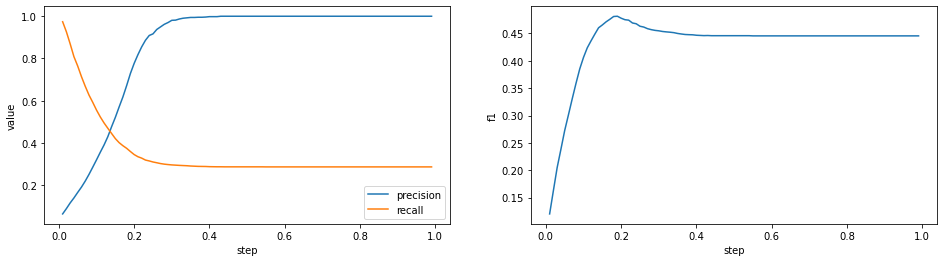

In [15]:
fig, axs = plt.subplots(1,2)
fig.set_figwidth(16)
sns.lineplot(y = report_fraud['precision'], x = report_fraud['step'], ax=axs[0], legend=True)
sns.lineplot(y = report_fraud['recall'], x = report_fraud['step'], ax=axs[0], legend=True)
axs[0].legend(['precision', 'recall'])
axs[0].set_ylabel('value')
sns.lineplot(y = report_fraud['f1'], x = report_fraud['step'], ax=axs[1])

Como já comentado anteriormente na modelagem, é muito importante alinhar com negócio o foco do produto, aqui tomamos f1 como star metric, mas poderia abrir mão da precisão para aumentar o recall, que seria até uma sugestão para próximos estudos.

- Confusion Matrix

In [16]:
threshold = 0.19

In [17]:
print(classification_report(y_test, change_threshold(y_pred_prob, threshold)))

              precision    recall  f1-score   support

           0       0.98      0.99      0.99     29097
           1       0.65      0.30      0.41       903

    accuracy                           0.97     30000
   macro avg       0.81      0.65      0.70     30000
weighted avg       0.97      0.97      0.97     30000



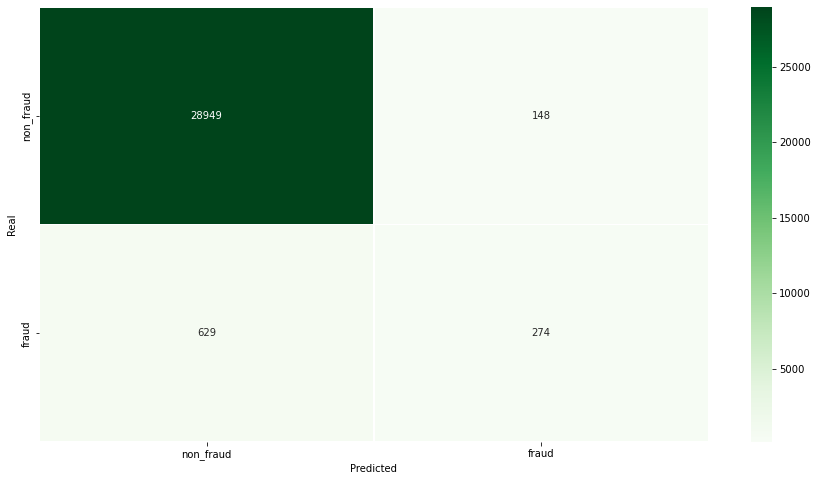

In [18]:
plt.figure(figsize=(15,8))
sns.heatmap(confusion_matrix(y_test, change_threshold(y_pred_prob, threshold)),
            cmap='Greens', annot=True, linewidths=.5, fmt='g',
            xticklabels=['non_fraud', 'fraud'], yticklabels=['non_fraud', 'fraud'])
plt.xlabel("Predicted"), plt.ylabel("Real");

Aqui foi construída a matriz de confusão para avaliar melhor as classificações e ter mais ideia dos FP e FN

# SHAP Analysis

Foi realizado uma análise de SHAP para saber melhor a significância das variávies utilizadas, ver a relevância de cada uma.

In [19]:
explainer = shap.TreeExplainer(model=loaded_model)

In [20]:
shap_values_train = explainer.shap_values(X_train, y_train)

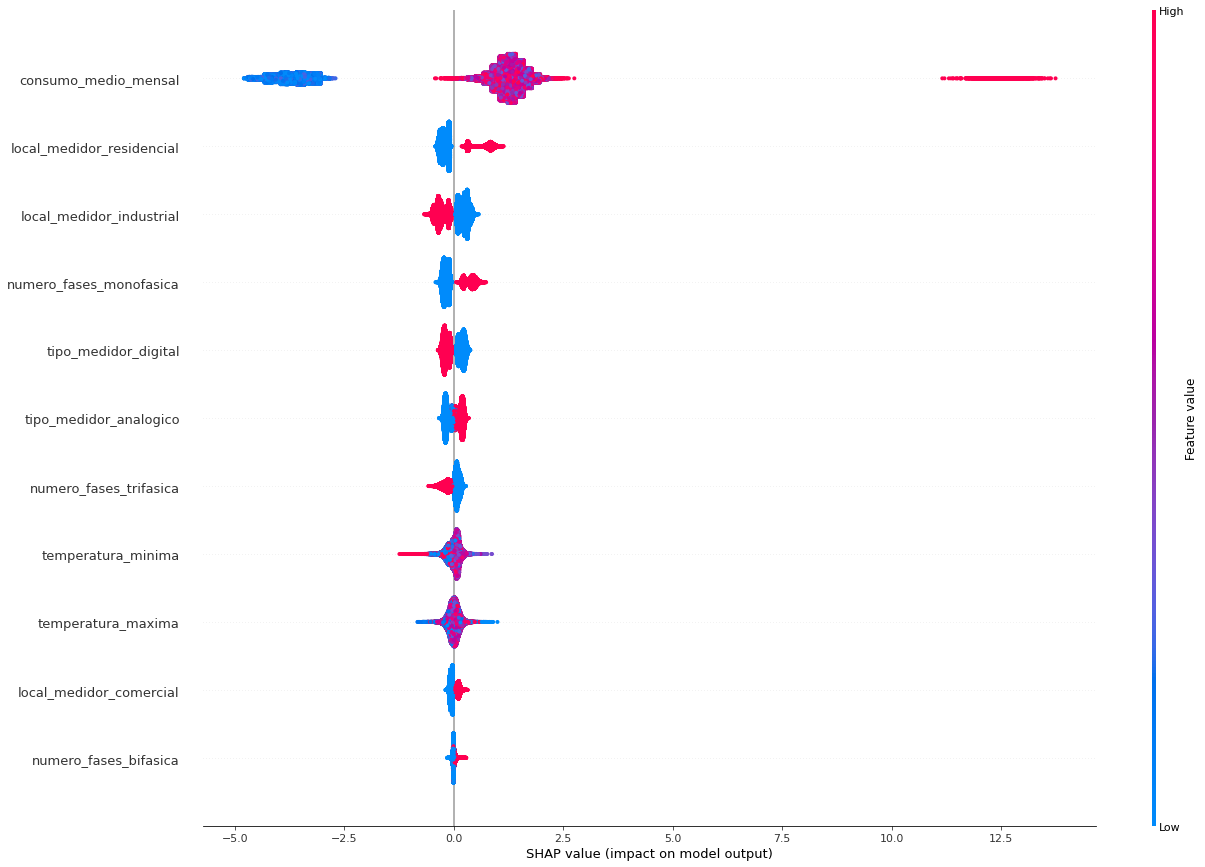

In [21]:
shap.summary_plot(shap_values_train, X_train, plot_type="dot", plot_size=(20,15));

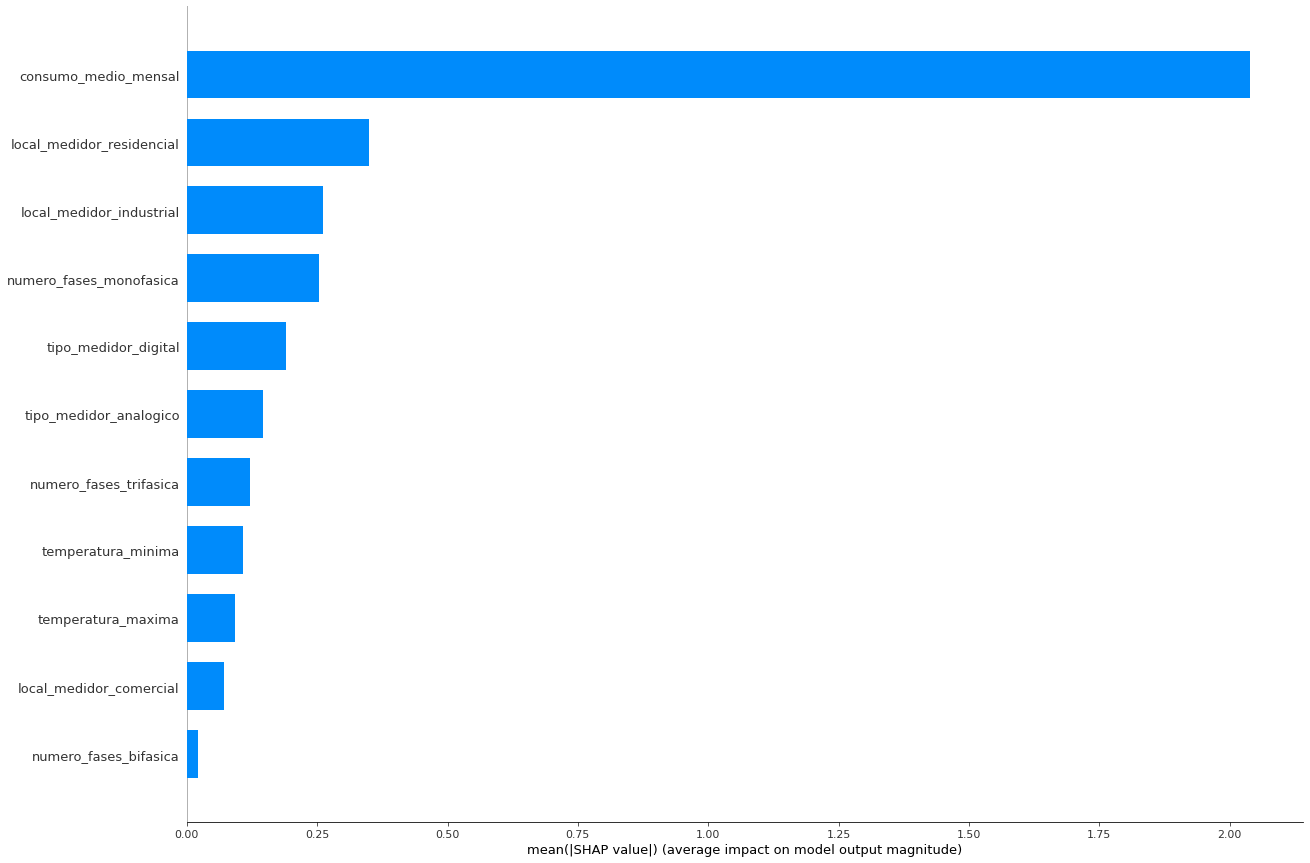

In [22]:
shap.summary_plot(shap_values_train, X_train, plot_type="bar", plot_size=(20,15));

- O que foi comentado no EDA se concretiza aqui também, quando foi apresentada a alta correlação de pessoas com consumo mensal elevado e fraude. É visto aqui que essa é a variável mais impactante;
- No entanto, deixa desconfiancia a sua alta significância diante das demais variáveis. Com isso é interessante avaliar um dummy classifier somente com base nela, para ver se o modelo não está se baseando só na mesma praticamente.

In [23]:
Xy_train = pd.concat([X_train,y_train],axis=1)

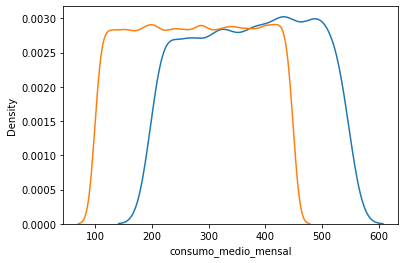

In [24]:
sns.kdeplot(Xy_train[Xy_train['classe_cliente_fraudador'] == 1]['consumo_medio_mensal'])
sns.kdeplot(Xy_train[Xy_train['classe_cliente_fraudador'] == 0]['consumo_medio_mensal'])

- É visto novamente aquele comportamento anômalo já identificado anteriormente na faixa dos 450, sendo assim para teste de dummy classifier usaremos esse valor de referência.

In [25]:
X_pred_fraud = Xy_train[Xy_train['consumo_medio_mensal'] >= 450].drop('classe_cliente_fraudador', axis = 1)
y_pred_fraud = Xy_train[Xy_train['consumo_medio_mensal'] >= 450]['classe_cliente_fraudador']

In [26]:
y_dummy_pred = X_test['consumo_medio_mensal'].apply(lambda x: 1 if x>=450 else 0)

In [27]:
f1_score(y_test, y_dummy_pred)

0.4295652173913043

- É visto que esse valor de f1 é o mesmo que o modelo com tuning apresentava, sendo o modelo até então batido por um dummy classifier, podendo descartar o mesmo;
- Assim é interessante reavaliar a modelagem até então, possivelmente treinando sem essa feature de consumo para ver o comportamento.

In [28]:
n_X_train = X_train.drop('consumo_medio_mensal', axis = 1)
n_X_test = X_test.drop('consumo_medio_mensal', axis = 1)

In [29]:
models_evaluation(n_X_train, n_X_test, y_train, y_test, balance_bagging=False, weights=False)

{'rfc_mm': 0.0,
 'dtc_mm': 0.0,
 'lg_mm': 0.0,
 'gd_mm': 0.0,
 'rfc_std': 0.0,
 'dtc_std': 0.0,
 'lg_std': 0.0,
 'gd_std': 0.0}

- Pelo que vemos nesse comportamento o modelo tem um viés extremamente alto quando falamos de consumo_medio_mensal, sendo as outras variáveis irrelevantes perto dessa;
- Sendo assim nenhum dos modelos de classificação se encaixou bem, no entanto, isso não foi por causa dos modelos e sim pelas variáveis, não sendo necessário testar outras modelagens;
- Assim é importante rever as variáveis antes de testar uma nova modelagem, aqui também é visto a importância de uma EDA bem realizada.